In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
!pip install git+https://github.com/pulse2percept/pulse2percept

  Cloning https://github.com/pulse2percept/pulse2percept to /tmp/pip-req-build-ffyi0_is
  Running command git clone -q https://github.com/pulse2percept/pulse2percept /tmp/pip-req-build-ffyi0_is


In [ ]:
from google.colab import files

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from matplotlib import pyplot as plt
import networkx as nx

from google.colab.patches import cv2_imshow
from collections import Counter, deque
from itertools import islice

import pulse2percept as p2p

In [ ]:
!gdown https://drive.google.com/uc?id=1iWeXStNAEqbXDLCBGWagsmVzm8tLaqKd
!ls

Downloading...
From: https://drive.google.com/uc?id=1iWeXStNAEqbXDLCBGWagsmVzm8tLaqKd
To: /content/rgb_sal_seg.zip
100% 19.3M/19.3M [00:00<00:00, 117MB/s] 
axons.pickle  debug.log  results  rgb_sal_seg.zip  sample_data


In [ ]:
!unzip -q rgb_sal_seg.zip

replace results/rgb0088_saliency.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
folder = "results"

In [ ]:
def get_points_cloud(layer, wind=1):
  return [(i,j) for i in range(layer.shape[0]) for j in range(layer.shape[1]) if layer[i,j] and not np.all(layer[i-wind:i+wind, j-wind:j+wind])]

In [ ]:
def get_shortest_distances(points_cloud_l1, points_cloud_l2):
  min_dist = ((points_cloud_l1[0][0] - points_cloud_l2[0][0])**2 + (points_cloud_l1[0][1] - points_cloud_l2[0][1])**2)**(1/2)
  min_points = ((points_cloud_l1[0][0], points_cloud_l1[0][1]), (points_cloud_l2[0][0], points_cloud_l2[0][1]))
  for x1,y1 in points_cloud_l1:
    for x2,y2 in points_cloud_l2:
      dist = ((x1 - x2)**2 + (y1 - y2)**2)**(1/2)
      if dist < min_dist:
        min_dist = dist
        min_points = ((x1, y1), (x2, y2))
  return min_dist, min_points

In [ ]:
def masks_to_graph(segmentation_masks: np.ndarray):
  diameter = 30# how many "pixels" phospehene are?
  graph = nx.Graph()
  for ind1 in range(len(segmentation_masks)):
    graph.add_node(ind1)
    for ind2 in range(ind1+1, len(segmentation_masks)):
      points1 = get_points_cloud(segmentation_masks[ind1])
      points2 = get_points_cloud(segmentation_masks[ind2])
      #diameter = max(max(max(points1, key x,y: x) - min(points1, key x,y: x), max(points1, key x,y: y) - min(points1, key x,y: y)),
                    # max(max(points1, key x,y: x) - min(points1, key x,y: x), max(points1, key x,y: y) - min(points1, key x,y: y)))
      distance, points = get_shortest_distances(points1, points2)
      if distance < diameter:
        graph.add_edge(ind1, ind2, distance=distance)
  return graph

In [ ]:
def color_me(graph):
  colors = nx.coloring.greedy_color(graph, strategy='random_sequential')
  return colors

In [ ]:
def color_me2(graph, color_num=4):
  colors = nx.coloring.equitable_color(graph, color_num)
  return colors

In [ ]:
def paint_me(segm, colors):
  result = np.zeros((480, 640))
  # min_border = 30
  # instances_n = len(set(colors.values()))
  # modifier = (255 - min_border) // (instances_n + 1) 
  for ind, layer in enumerate(segm):
    color = colors[ind]+1 #(colors[ind]+1) * modifier  
    result[layer] = color
  return result

In [ ]:
img_num = "0675"
segm = np.load(os.path.join(folder,f"rgb{img_num}_segmentation.npy"))

In [ ]:
graph = masks_to_graph(segm)

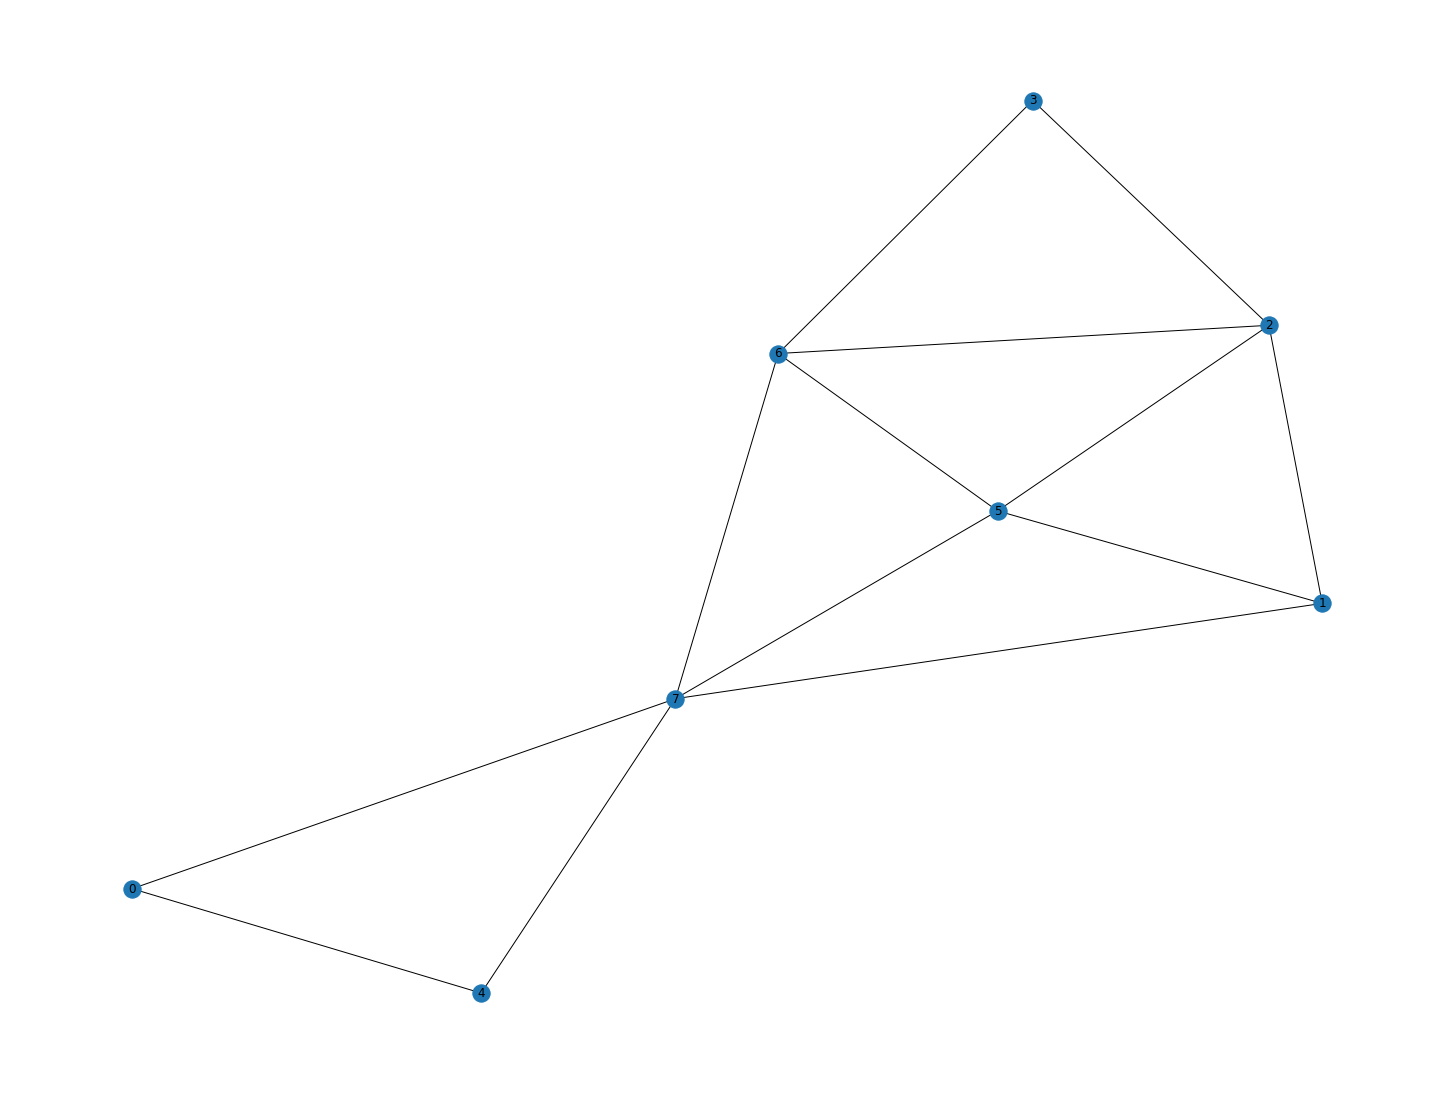

In [ ]:
nx.draw(graph, with_labels=True)

In [ ]:
graph.edges

EdgeView([(0, 4), (0, 7), (4, 7), (7, 1), (7, 5), (7, 6), (1, 2), (1, 5), (2, 3), (2, 5), (2, 6), (5, 6), (3, 6)])

In [ ]:
colors = color_me(graph)
colors

{0: 0, 1: 0, 2: 1, 3: 2, 4: 2, 5: 2, 6: 0, 7: 1}

In [ ]:
recolor_bfs(colors, graph)

{0: 2, 1: 2, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 0}

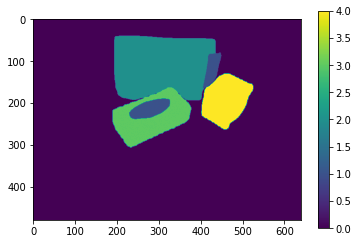

In [ ]:
segm_img = paint_me(segm, colors)
plt.imshow(segm_img)
plt.colorbar()

In [ ]:

def prothesisPlot(image, ax, rho=70, axlambda=30):
  model = p2p.models.AxonMapModel(xrange=(-10, 10), yrange=(-10, 10), rho=rho, axlambda=axlambda)
  model.build()
  implant = p2p.implants.ProsthesisSystem(p2p.implants.ElectrodeGrid((32, 32), 4000/50,
                                               etype=p2p.implants.DiskElectrode,
                                               r=10))
  seg = p2p.stimuli.images.ImageStimulus(image)
  implant.stim=seg.resize(implant.earray.shape)
  percept=model.predict_percept(implant)
  percept.plot(ax=ax)
  # return percept

In [ ]:
def recolor_bfs(colors: dict, graph: nx.Graph) -> dict:
    if not colors or not len(graph.nodes):
        return {}
    amount_of_colors = len(set(colors.values()))
    colors_range = deque(range(amount_of_colors))
    colors_freqs = Counter(colors.values())

    most_common_color = colors_freqs.most_common(1)[0][0]
    result = {most_common_color: colors_range.pop()}

    # find starting point - any node of most_common_color
    current_point = None
    for v in graph.nodes:
        if colors[v] == most_common_color:
            current_point = v
            break
    assert current_point is not None

    stack = deque()
    while len(result) < amount_of_colors:
        neighs = graph.neighbors(current_point)
        neighs = [v for v in neighs if colors[v] not in result]

        neighs_colors = {colors[v] for v in neighs}
        if neighs_colors:
            step = len(colors_range) // len(neighs_colors)
            colors_to_use = deque(islice(colors_range, None, None, step))
            assert len(colors_to_use) >= len(neighs_colors)  # maybe even ==
            for v in neighs:
                if colors[v] not in result:
                    result[colors[v]] = colors_to_use.pop()
                    colors_range.remove(result[colors[v]])
    
            colors_range.reverse()
            
        stack.extend(neighs)
        current_point = stack.popleft()

    return {k: result[v] for k, v in colors.items()}

In [ ]:
def recolor_me(colors, graph):
  replace_dict = {val: ind for ind, val in enumerate(sorted(set(colors.values()), key=lambda x: list(colors.values()).count(colors[x])))}
  result_dict = {}
  for key in colors:
    result_dict[key] = replace_dict[colors[key]]
  return result_dict

In [ ]:
def combination(img1, img2, prc1, prc2):
  assert img1.shape == img2.shape
  img1 = (img1 - img1.min()) / (img1.max() - img1.min())
  img2 = (img2 - img2.min()) / (img2.max() - img2.min())
  res = img1 * prc1 + img2 * prc2
  res = (res - res.min()) / (res.max() - res.min()) * 255
  return res

rgb0710


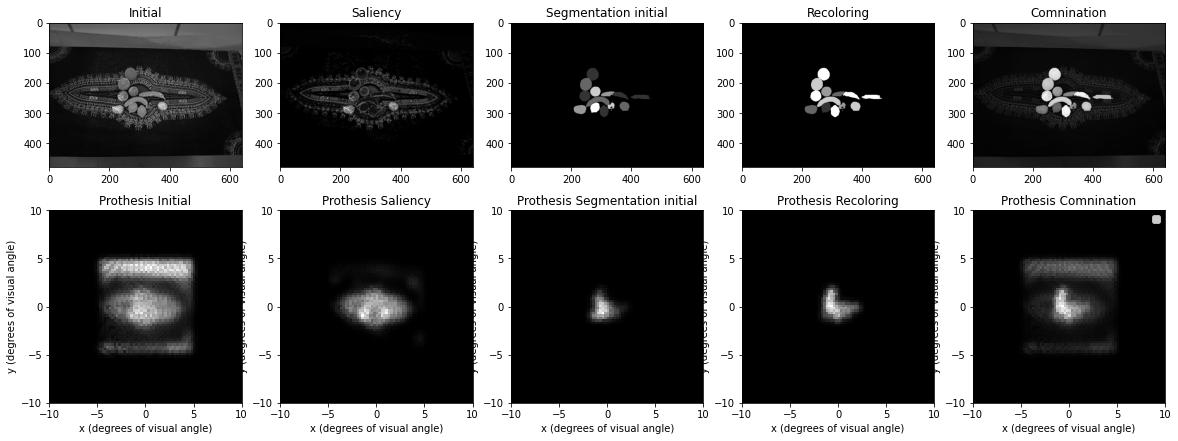







rgb0904


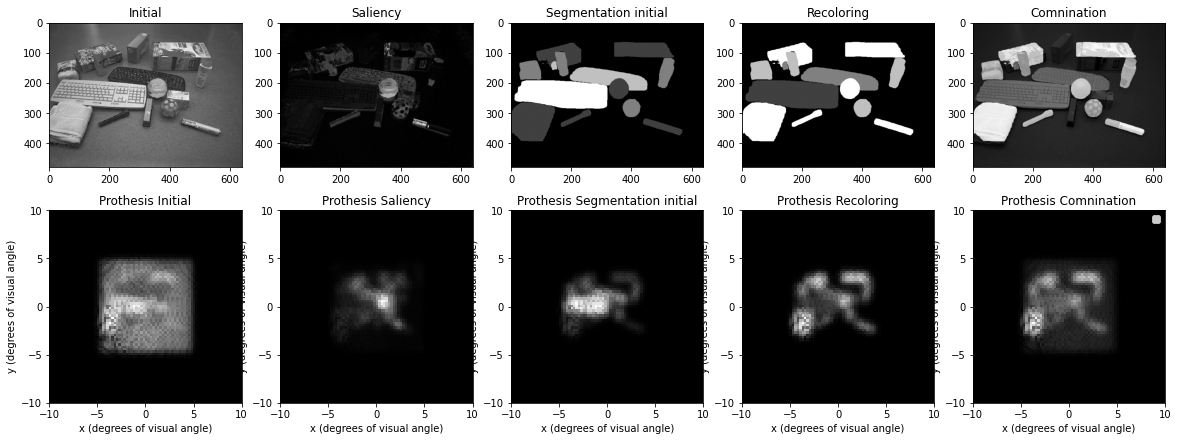







rgb2120


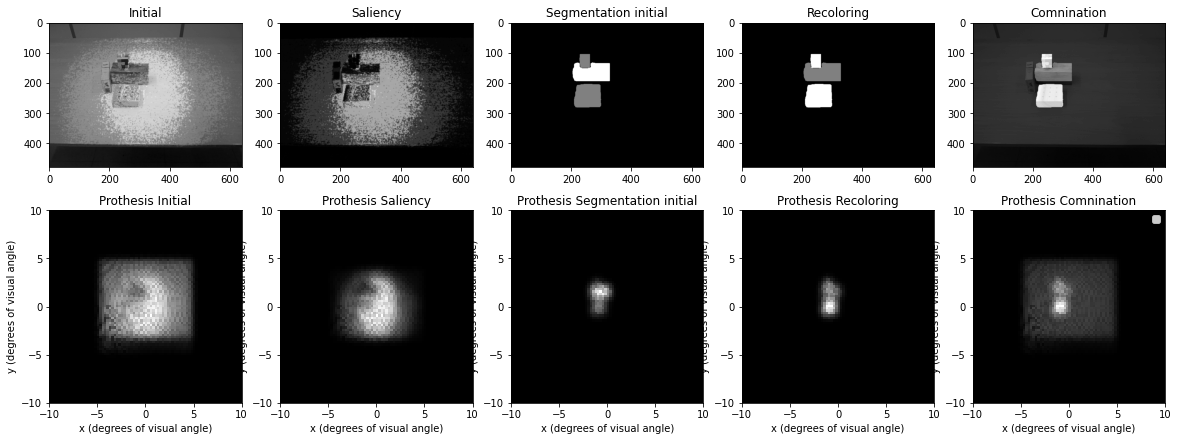







rgb0195


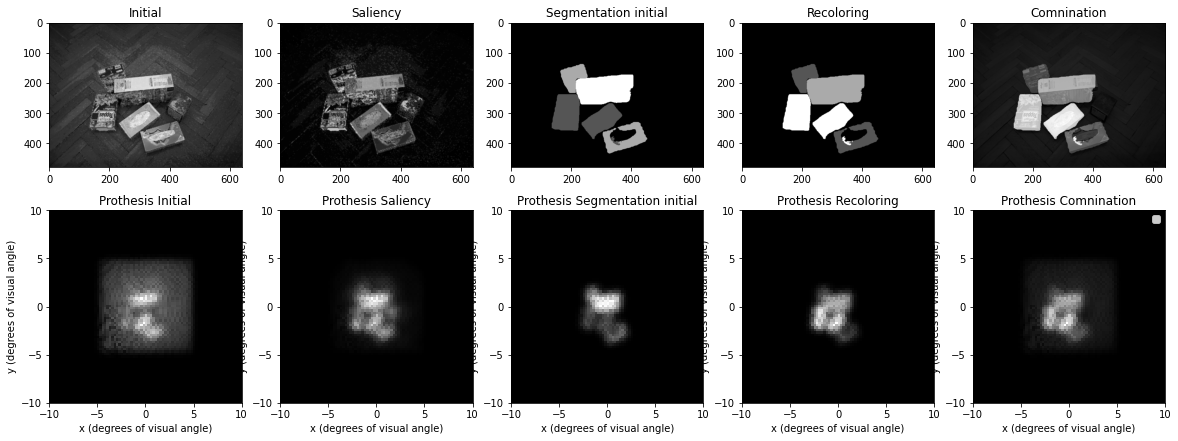







rgb2154


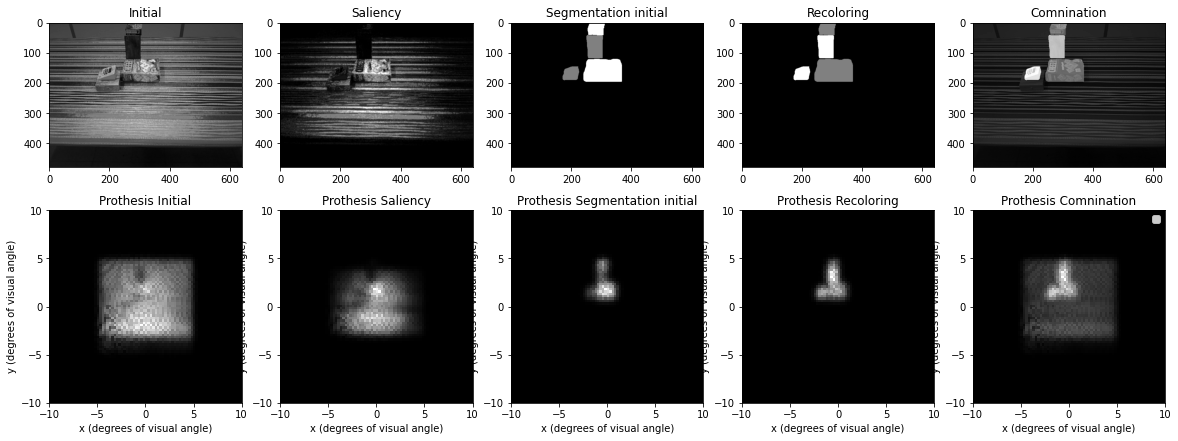







rgb0688


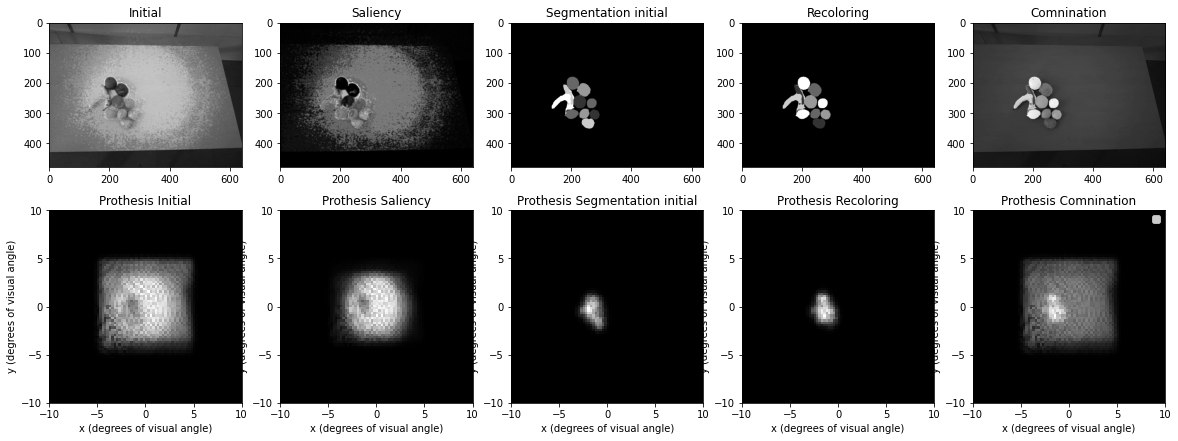







rgb0125


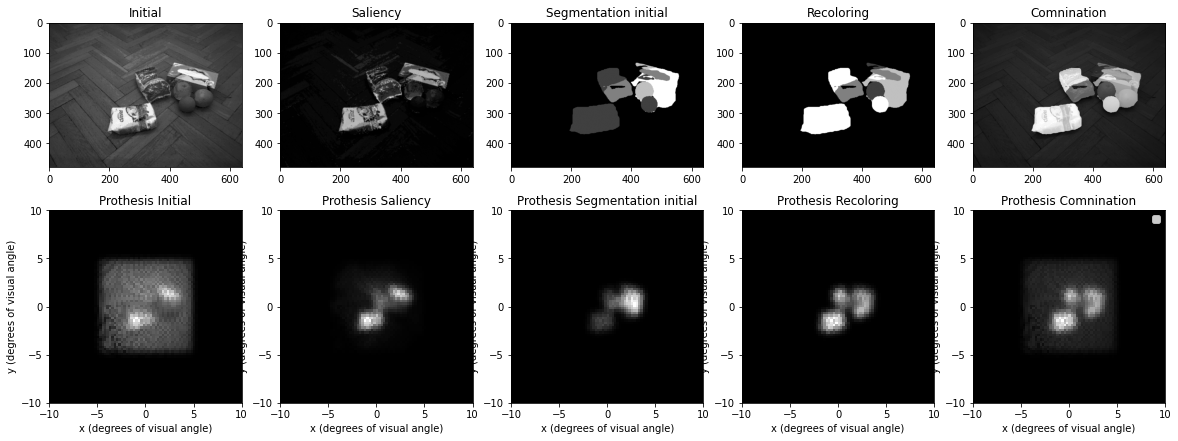







rgb0268


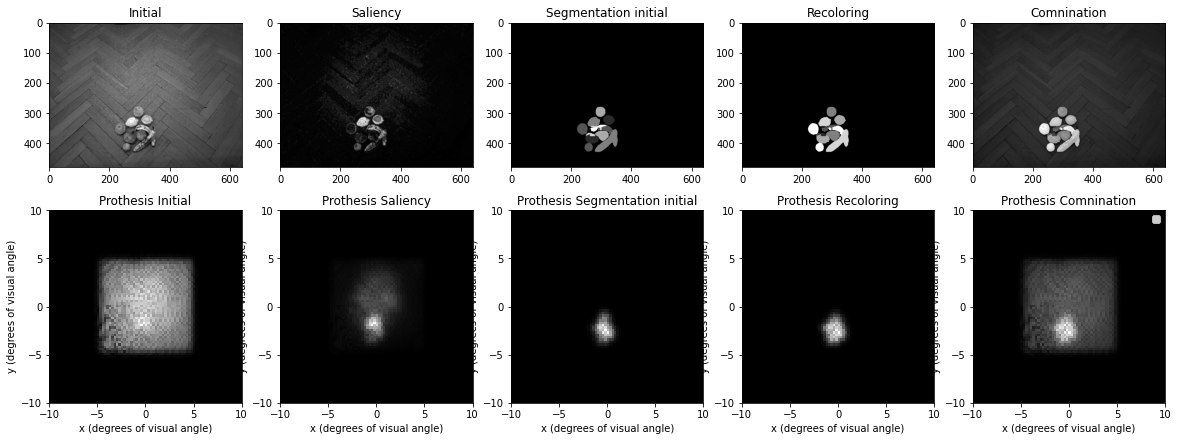







rgb0032


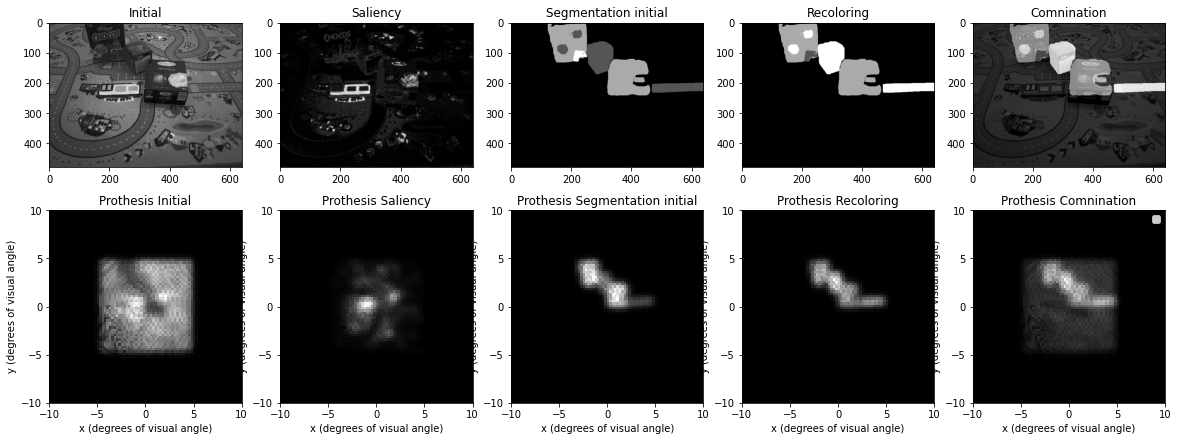







rgb0156


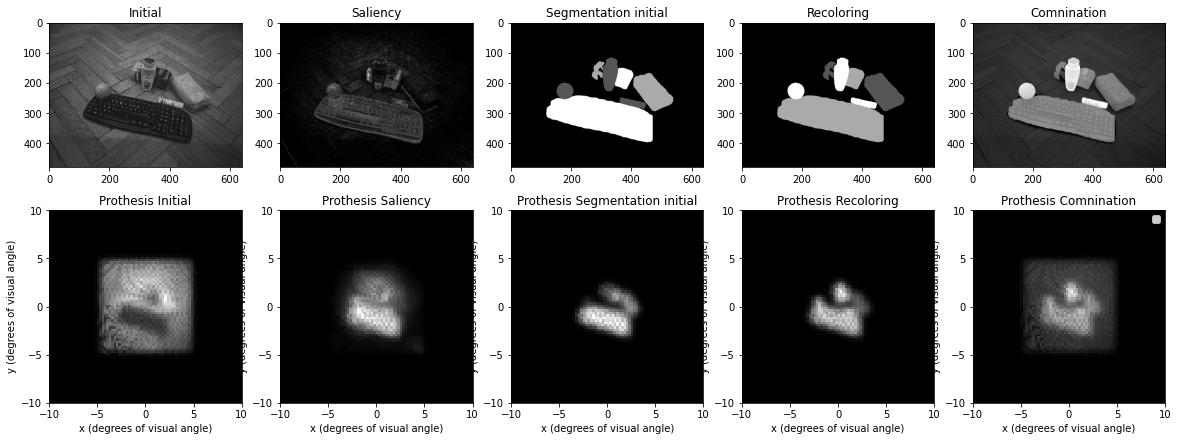







rgb0742


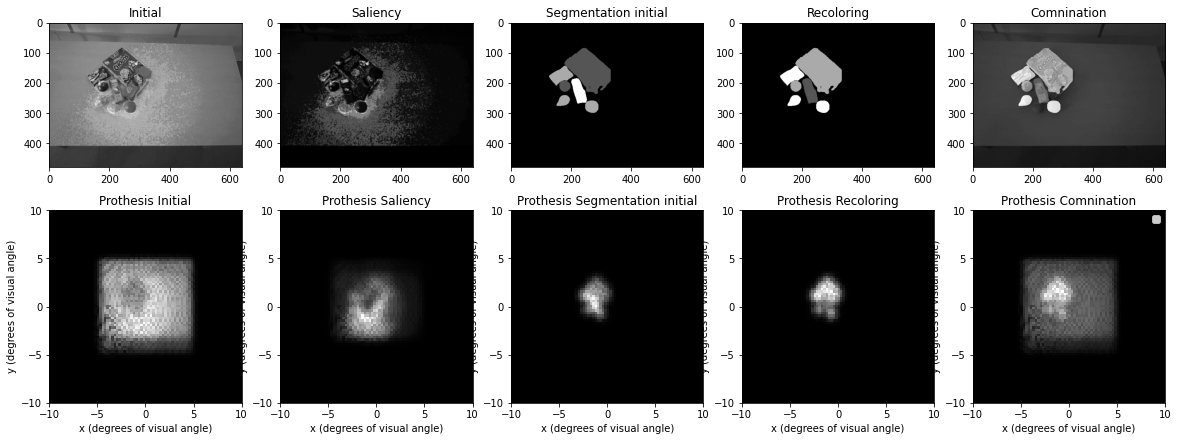







rgb0675


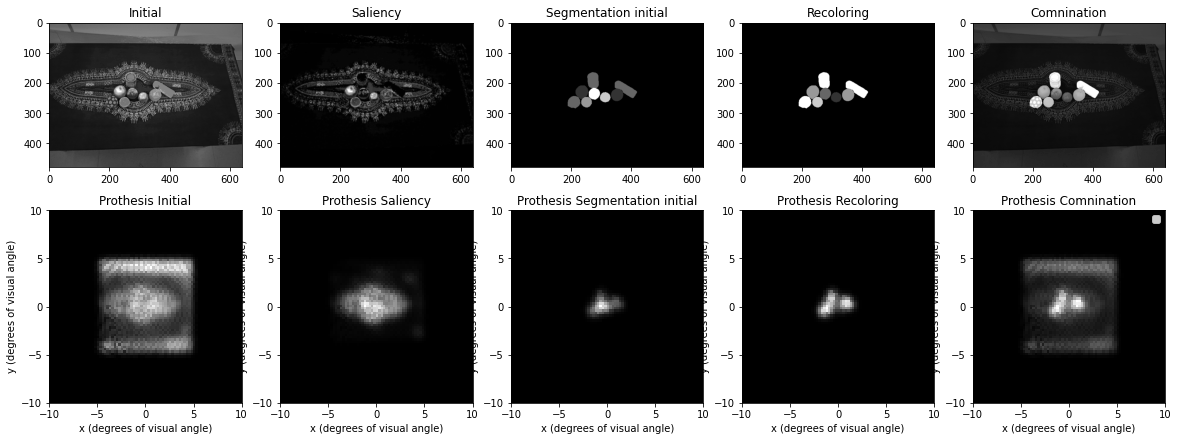







rgb0109


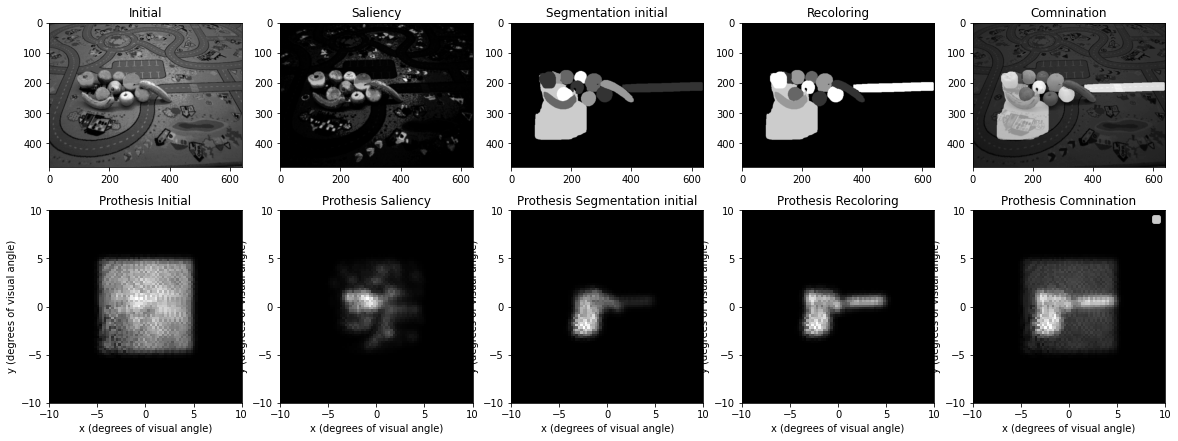







rgb0013


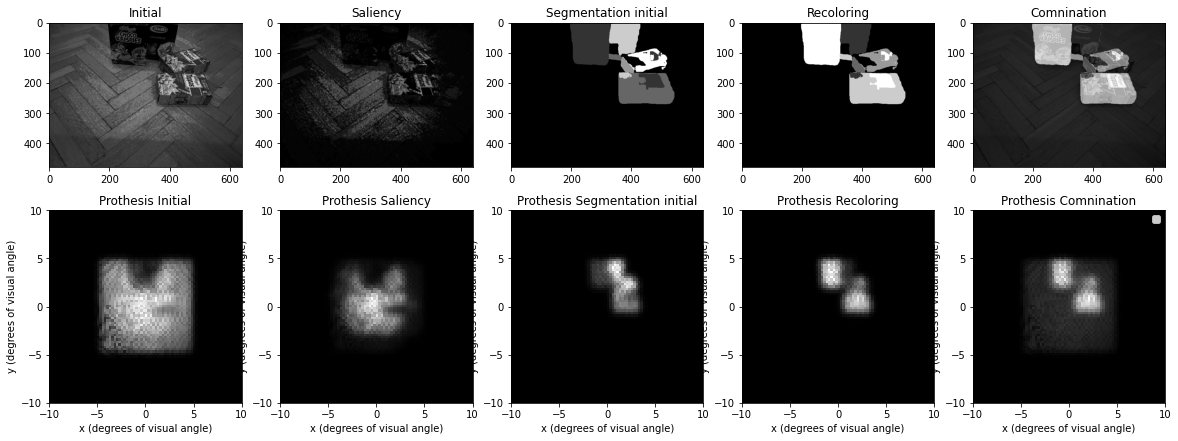







rgb0049


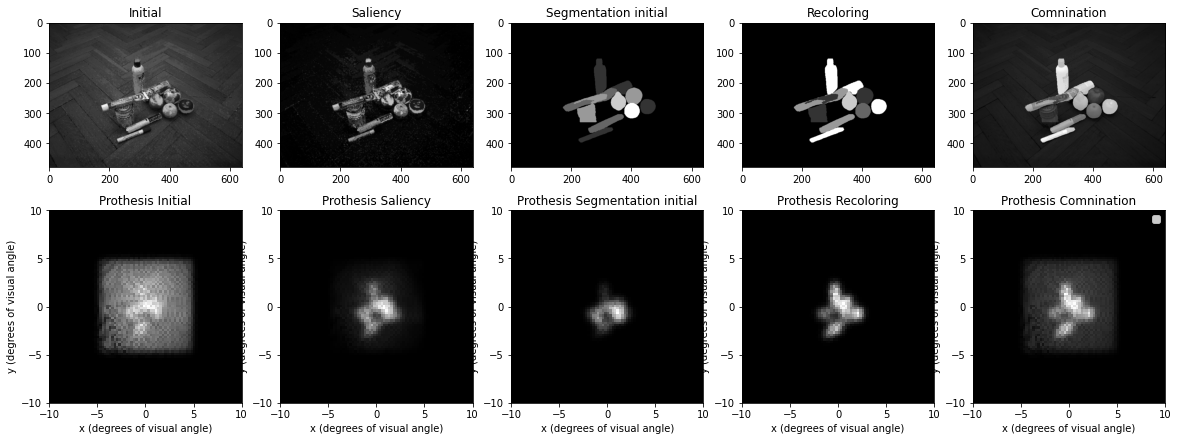







rgb0088


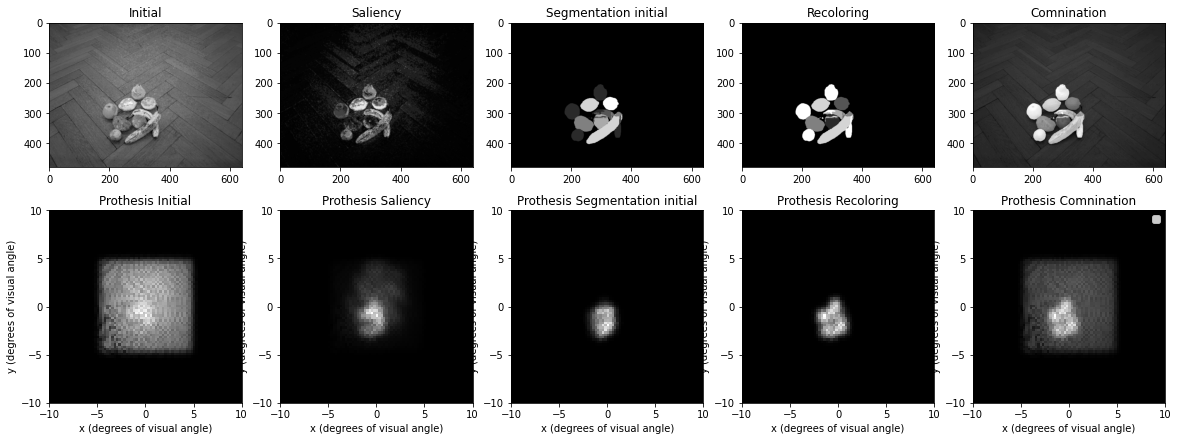







rgb2073


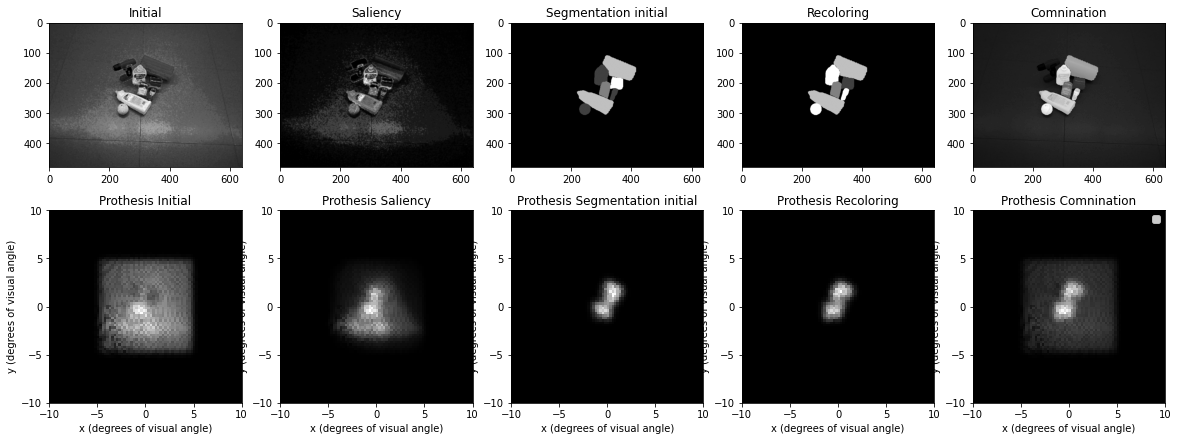







rgb1323


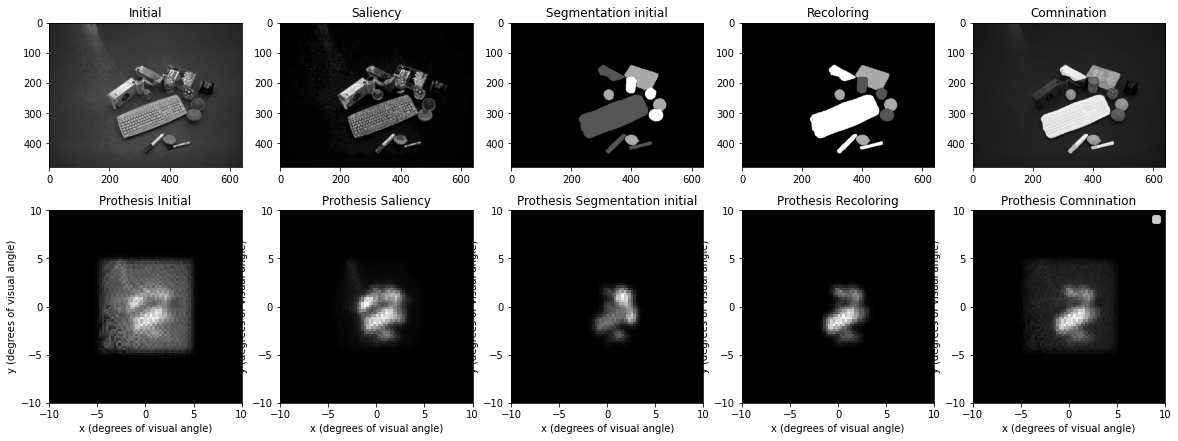







rgb0168


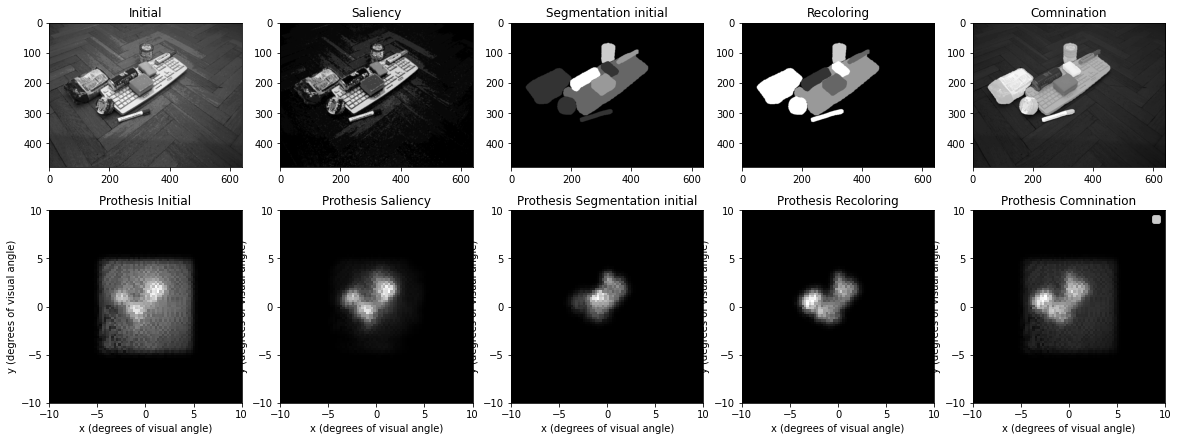







rgb0805


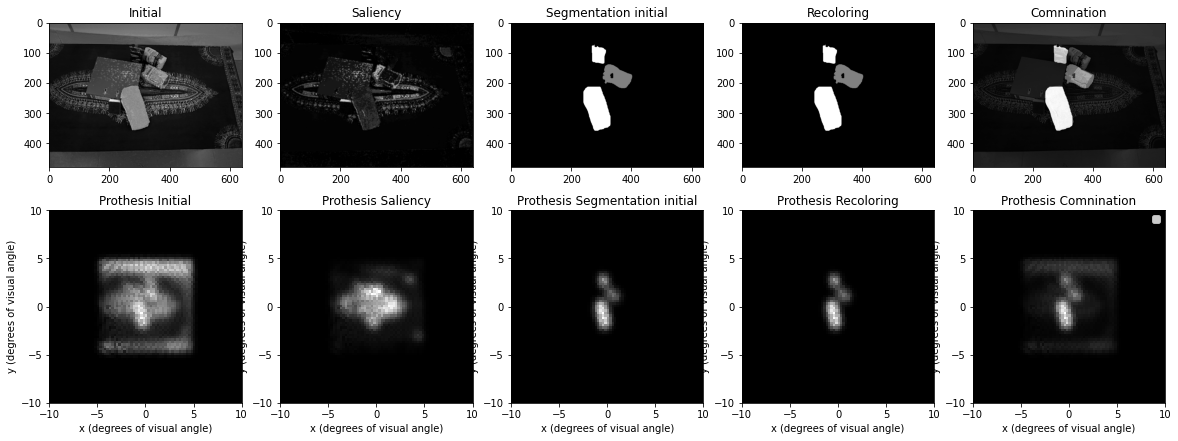







rgb1950


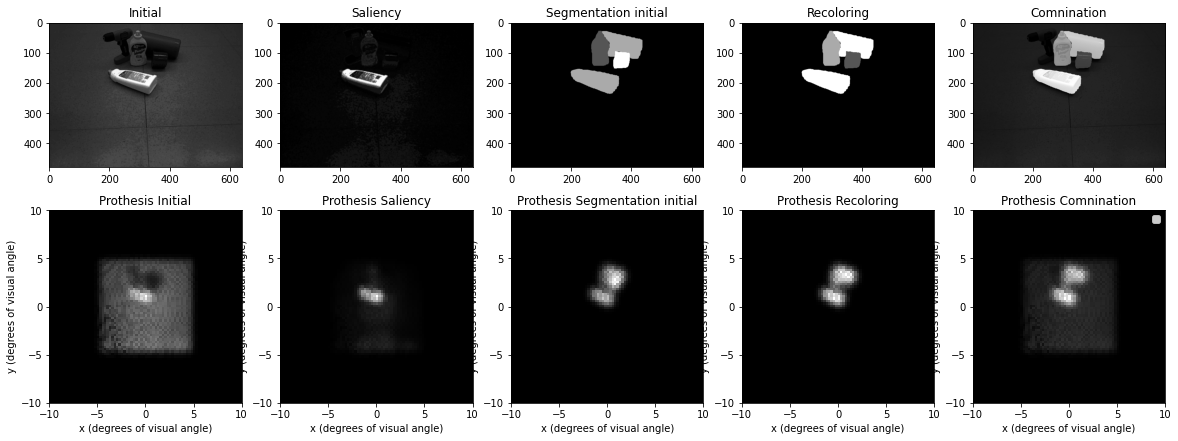







rgb2358


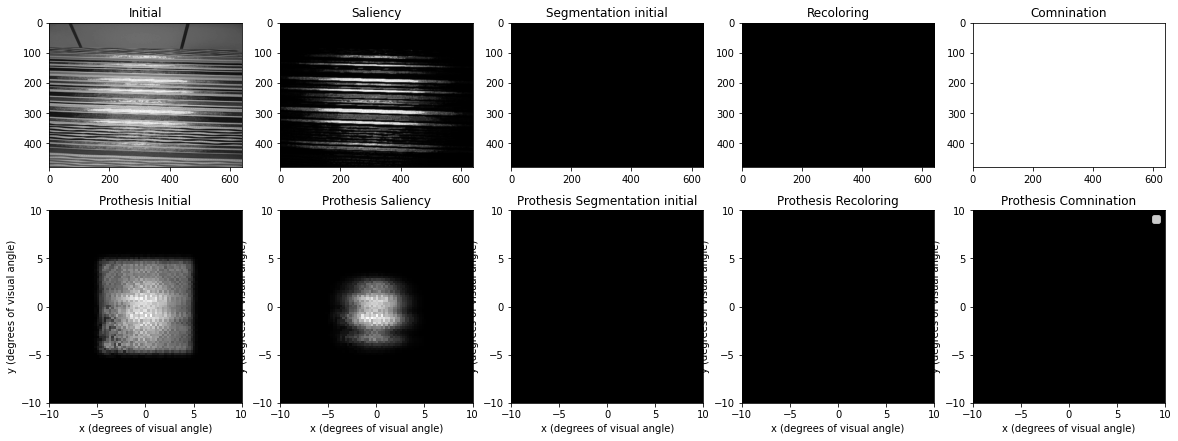







rgb2298


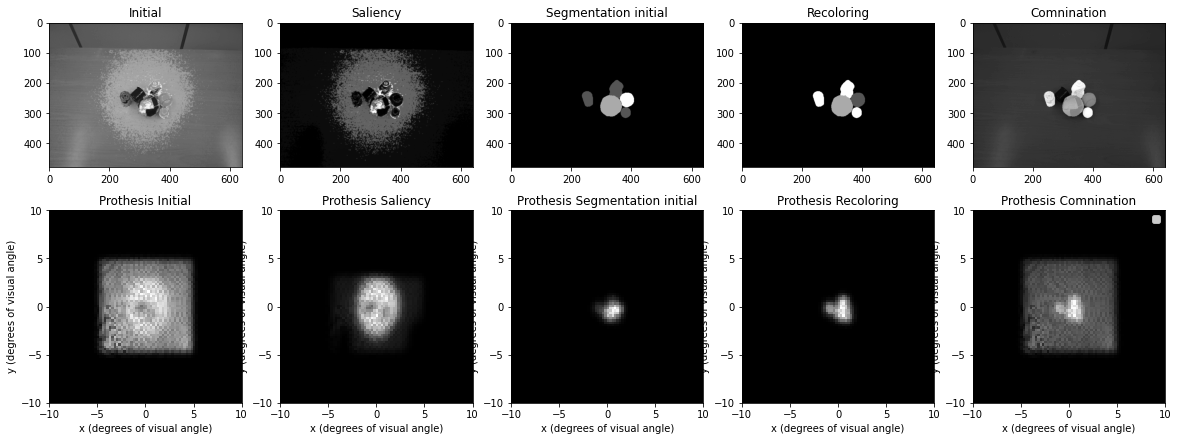







rgb2189


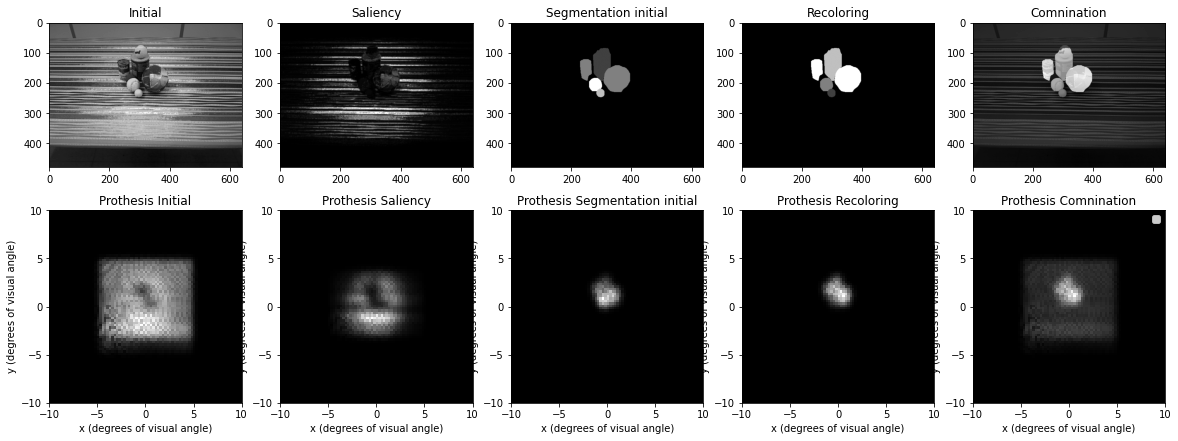







rgb0059


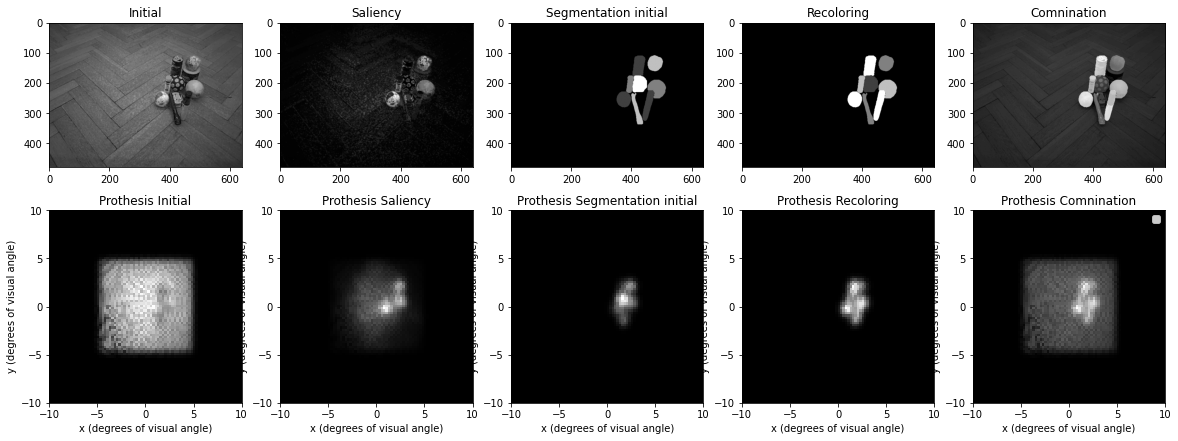







rgb0214


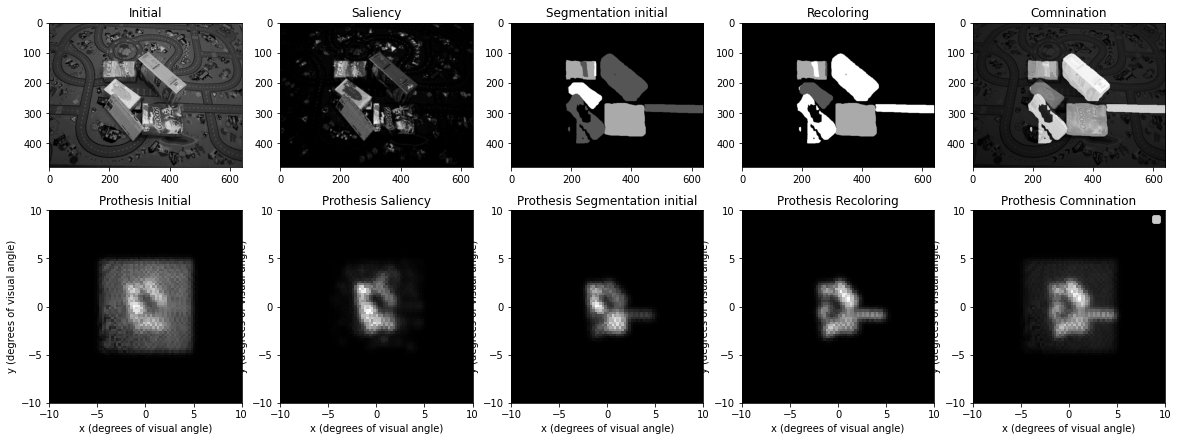







rgb1991


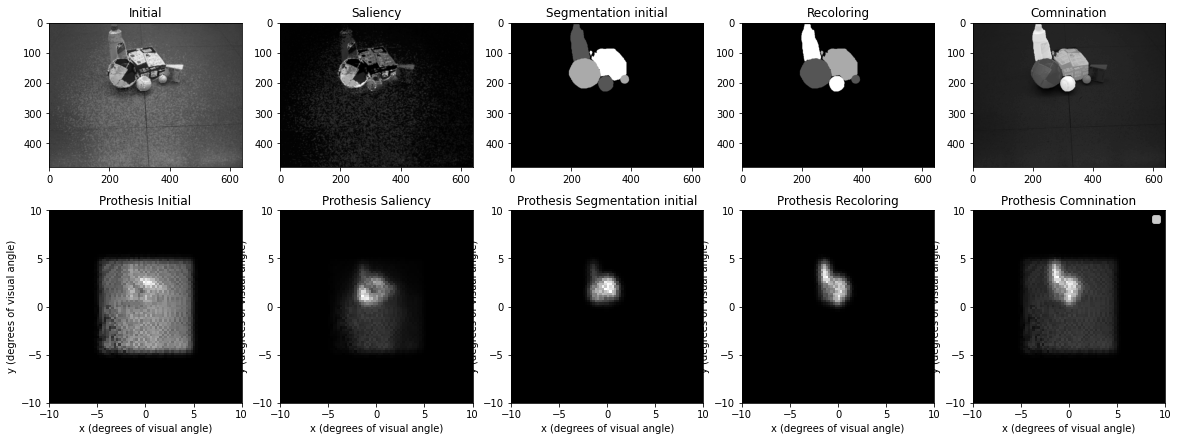







rgb0002


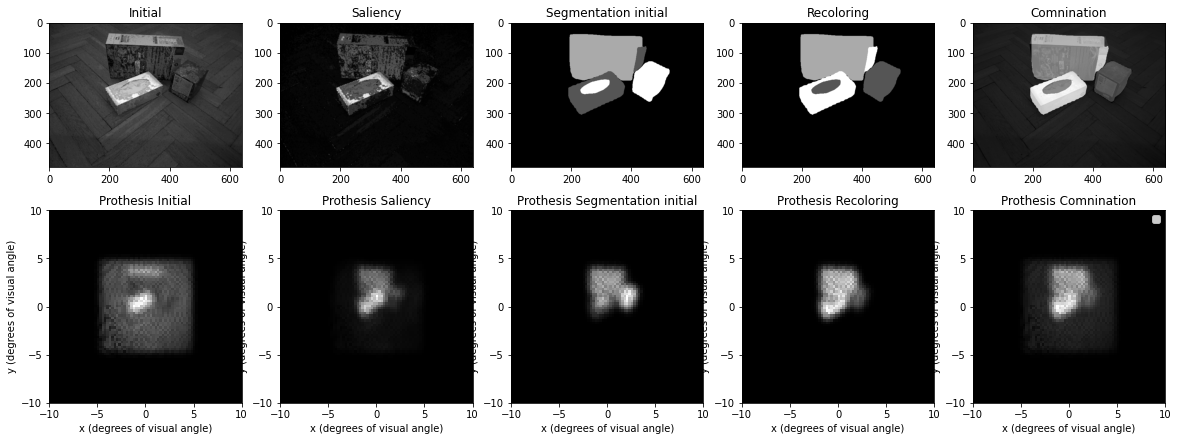

In [ ]:
plt.rcParams['figure.figsize'] = [20, 15]
files = set(i[:7] for i in os.listdir(folder))
for pic in files:
  print(pic)


  rgb = np.load(os.path.join(folder,f"{pic}_rgb.npy"))
  sal = np.load(os.path.join(folder,f"{pic}_saliency.npy"))
  segm = np.load(os.path.join(folder,f"{pic}_segmentation.npy"))
  gray_scale = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
  graph = masks_to_graph(segm)
  colors = color_me(graph)
  try:
    colors1 = recolor_bfs(colors, graph)
  except Exception as e:
    print(e)
    print(colors)
    print(graph.edges)
    colors1 = colors
  segm_img = paint_me(segm, colors)
  after_recoloring1 = paint_me(segm, colors1)

  to_print = [combination(gray_scale, sal, 0.5, 0.5), sal, segm_img, after_recoloring1, combination(gray_scale, after_recoloring1, 0.3, 0.7)]
  labels = ["Initial", "Saliency", "Segmentation initial", "Recoloring", "Comnination"]
  x = 2
  y = len(to_print)
  fig, axs = plt.subplots(2, y)
  for i in range(y):
    axs[0, i].imshow(to_print[i], cmap="gray")
    axs[0, i].set_title(labels[i])
  for i in range(y):
    prothesisPlot(to_print[i], axs[1, i], rho=90, axlambda=20)
    axs[1, i].set_title("Prothesis " + labels[i])
  plt.legend()
  fig.subplots_adjust(hspace=-0.65)
  # plt.tight_layout()
  plt.show()
  print("\n"*5)


In [ ]:
0001_original_N
0001_blue_N